In [1]:
import pandas as pd
from itertools import product, count

In [2]:
from matplotlib import pyplot as plt

In [3]:
import random

In [4]:
import networkx as nx

## Primo network: famiglie

In [5]:
# Generatore di nodi - identificati con interi:
c = count()

edges = []
nodes = []

# Inizialmente, è infetto solo l'individuo 0:
sick = [0]

for gr in range(1, 6):
    # Famiglie di 4 persone...
    gr_nodes = [next(c) for i in range(4)]
    
    for i in gr_nodes:
        nodes.append((i, gr, int(i in sick)))
    
    # ... tutte connesse tra di loro:
    for i, j in product(gr_nodes, gr_nodes):
        if i != j:
            edges.append((i, j, 1))

In [6]:
df_edges = pd.DataFrame(edges, columns=['i', 'j', 'color'])
df_nodes = pd.DataFrame(nodes, columns=['i', 'color', 'sick'])

In [7]:
df_edges.to_csv('data/famiglie_edges.csv', index=False)
df_nodes.to_csv('data/famiglie_nodes.csv', index=False)

#### Figura

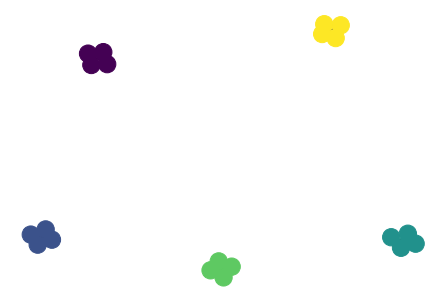

In [8]:
G = nx.Graph()
G.add_edges_from([e[:2] for e in edges])
nx.draw(G, node_color=[n[1] for n in nodes])

## Secondo network: amici

In [9]:
# Per la riproducibilità:
random.seed(414)

# Riutilizza i nodi di prima:
edges = list(edges)

# 100 passaggi di rewiring (che lascia inalterato il numero di vertici di ogni nodo):
for i in range(100):
    # estrai due vertici a caso:
    p1 = random.randint(0, len(edges) - 1)
    p2 = random.randint(0, len(edges) - 1)
    i1, j1, _ = edges[p1]
    i2, j2, _ = edges[p2]
    
    if i1 != i2 and j1 != j2:
        edges[p1] = (i1, i2, 2)
        edges[p2] = (j1, j2, 2)

In [10]:
df_edges = pd.DataFrame(edges, columns=['i', 'j', 'color'])

In [11]:
df_edges.to_csv('data/famiglie_amici_edges.csv', index=False)

#### FIgura

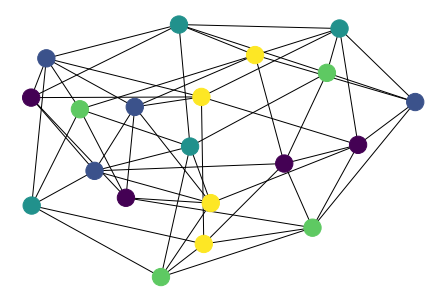

In [12]:
G = nx.Graph()
G.add_edges_from([e[:2] for e in edges])
nx.draw(G, node_color=[n[1] for n in nodes])

## Terzo network: famiglie più un amico a testa

In [13]:
# Per la riproducibilità:
random.seed(415)

# Per ogni nodo, memorizza i contatti:
nodes = {}

# Ripartiamo da zero con i nodi:
c = count()

# 30 famiglie...
for gr in range(1, 30):
    # ... da 4 persone l'una
    gr_nodes = [next(c) for i in range(4)]
    # ... connesse tra di loro
    for n in gr_nodes:
        nodes[n] = [m for m in gr_nodes if m != n]

# Amici ancora da assegnare:
to_match = set(nodes)

for n in nodes:
    if n not in to_match:
        continue
    # Assegna a n come amico...
    to_match.remove(n)
    # ... un altro amico a caso...
    peer = random.choice(list(to_match))
    # ... che non sia lui stesso:
    while peer == n:
        random.choice(list(to_match))

    # Presentazioni:
    nodes[n].append(peer)
    nodes[peer].append(n)

    # Non cerca più un amico:
    to_match.remove(peer)

# Calcoliamo le distanze

# Distanza massima:
GENERATIONS = 6

# Nodi già raggiunti
reached = {0 : 0}

# Nodi dell'ultima "generazione" (partiamo solo da 0)
last = [0]
# ... e della successiva
new = []

for generation in range(1, GENERATIONS):
    # Prendi un nodo appena raggiunto...
    for n in last:
        # ... e considera tutti i suoi contatti...
        for cont in nodes[n]:
            # ... non ancora raggiunti...
            if cont in reached:
                continue
            # ... nella nuova generazione.
            reached[cont] = generation
            new.append(cont)
    # Via con la prossima generazione
    last = new
    new = []

# Ricreiamo la lista di nodi e vertici nel solito formato
edges = []
points = []

generations = {g : [] for g in range(GENERATIONS)}
generations['Più di 5'] = []
for n in nodes:
    gen = reached.get(n, 'Più di 5')
    generations[gen].append(n)

# Scorriamo le generazioni una alla volta così che i nodi
# sono in ordine nel csv risultante:
for gen in generations:
    for n in generations[gen]:
        for p in nodes[n]:
            edges.append((n, p, 0))
        points.append((n, gen, 2 if gen == 0 else 1))

In [14]:
df_edges = pd.DataFrame(edges, columns=['i', 'j', 'color'])
df_nodes = pd.DataFrame(points, columns=['i', 'color', 'size'])

In [15]:
df_edges.to_csv('data/big_edges.csv', index=False)
df_nodes.to_csv('data/big_nodes.csv', index=False)

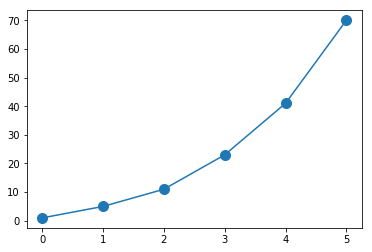

In [16]:
# 'color' è la distanza: contiamo i valori, ordiniamoli e facciamone la somma cumulata:
growth = df_nodes['color'].value_counts().drop('Più di 5').sort_index().cumsum()
growth.plot(marker='.', markersize=20)

In [17]:
growth.rename('Persone raggiunte').to_csv('data/big_growth.csv')

#### Figura

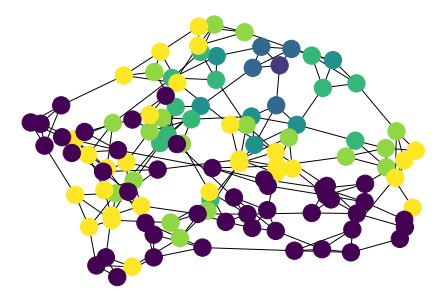

In [18]:
G = nx.Graph()
G.add_edges_from([e[:2] for e in edges])
nx.draw(G, node_color=[(-1 if n[1] == 'Più di 5' else n[1]) for n in points])